# Supplementary Information: Holmes *et al.* 2017

# 2. A simple model

In [1]:
%pylab inline

import numpy as np
import pandas as pd
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model

The simplest model we can construct is to treat each probe in each replicate (under both conditions) as an independent observation, and that the output value is some linear function of the input value, mediated by the experiment. This is a completely pooled model, and encodes the relationship that the measured *output* intensity is a linear function only of the measured *input* intensity.

We construct the following model of the experiment:

$$y_i = \alpha + \beta x_i + \epsilon_i$$

where we consider a *probe* $i$ to be a single spot on an array, so each probe is represented once in the data.

* $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
* $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
* $\alpha$: the linear intercept, this is a constant 'offset' for all *output* measurements relative to *input* measurements
* $\beta$: the linear slope, this is the relative change in measured intensity between *input* and *output* intensities
* $\epsilon_i$: error in the model prediction for probe $i$

### Stan model construction and fit

We need to define `data`, `parameters` and our `model` for `Stan`.

In the `data` block, we have:

* `N`: `int`, the number of probes (total data points, 
* `x`: `vector[N]`, the input log(intensity) values
* `y`: `vector[N]`, the output log(intensity) values

In the `parameter` block, we have:

* `a`: `real`, representative input log(intensity)
* `b`: `real`, effect on log(intensity) of passing through the experiment
* `sigma`: `real<lower=0>`, the error in the prediction

We define the model as $y \sim N(\alpha + \beta x, \sigma^2)$.

In [2]:
# define simple stan model
simple_model = """
data {
  int<lower=0> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real a;
  real b;
  real<lower=0> sigma;
}
model {
  y ~ normal(a + b * x, sigma);
}
"""

We map Python variables to the `stan` model, but to do this we need to load our cleaned, normalised data:

In [3]:
# load clean, normalised data
# data = pd.read_csv("output/normalised_array_data.tab", sep="\t")  # full dataset
data = pd.read_csv("output/reduced_normalised_indexed_array_data.tab", sep="\t")  # reduced dataset for test

In [4]:
# relate python variables to stan variables
simple_data_dict = {'N': len(data),
                    'x': data['log_input'],
                    'y': data['log_output']}

In [5]:
# run stan fit
simple_fit = pystan.stan(model_code=simple_model,
                         data=simple_data_dict,
                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4274033fca61c8b0dda563d365d2ce4d NOW.


## Inspecting the fit

We can inspect the fitted parameter estimates straightforwardly:

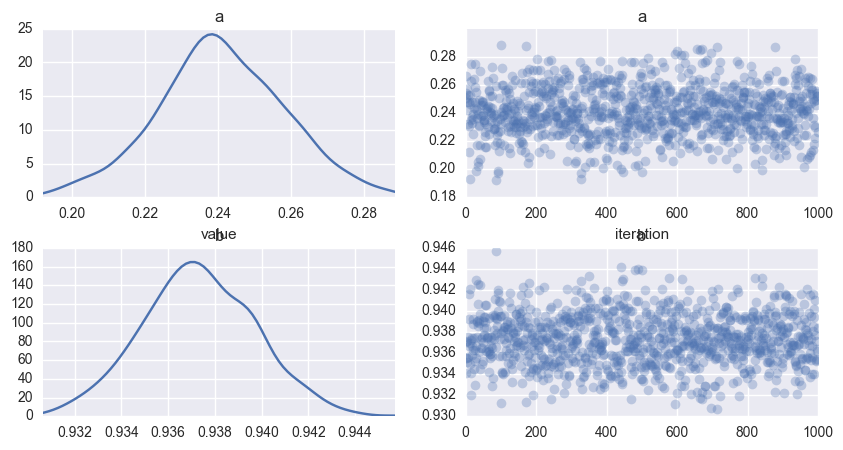

In [6]:
# Plot fitted parameters
tools.plot_fit_params(simple_fit, ['a', 'b'])

This simple model fit gives us (for the full dataset) mean estimates of $\alpha \approx 99$ and $\beta \approx 0.8$, and the credibility intervals are quite tight around those values - they are almost certainly non-zero:

In [7]:
# mean estimates
a_mean = simple_fit['a'].mean()
b_mean = simple_fit['b'].mean()
print('alpha: {0:.3f}'.format(a_mean),
      'beta: {0:.3f}'.format(b_mean))

alpha: 0.241 beta: 0.937


Taking this model at face value, the slope $\beta < 1$ implies that we should expect overall that the *output* intensity for any probe to be lower than its *input* intensity. This is a slightly disappointing result in that we hope to identify genes with higher *output* intensity, as a goal of the experiment, but more positively we might consider that there could be an overwhelming background of genes about which we could say it is deleterious for them to be carried through the experiment, and those that stand out for being enriched in *output* intensity may be easier to identify.

In [8]:
# 50% intervals
print(tools.print_intervals(simple_fit, 'a', 50))
print(tools.print_intervals(simple_fit, 'b', 50))

a 50%CI: 0.230..0.252
b 50%CI: 0.936..0.939


But does the model fit the data very well?

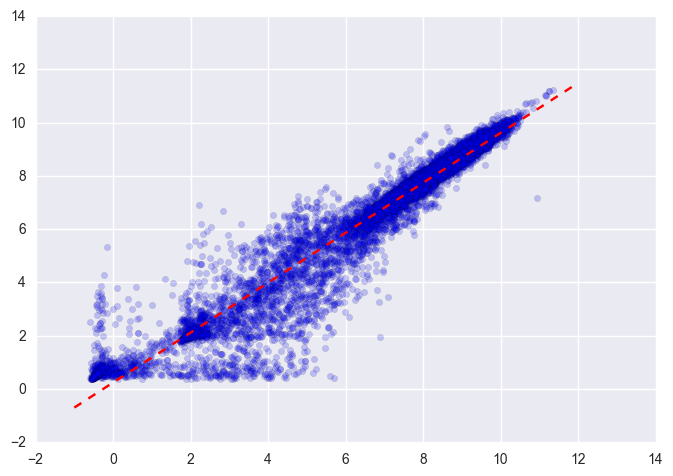

In [9]:
# Plot the fitted model on the data
plt.scatter(data['log_input'], data['log_output'], alpha=0.2)
xvals = np.linspace(-1, 12)
plt.plot(xvals, a_mean + b_mean * xvals, 'r--');

There is certainly a linear relationship betweeen input and output, and the model fit tracks that reasonably well. But there's quite a bit of variation around that fit, that may reflect effects that we could capture with a more complex model. 

Specifically, this model tells us nothing useful about a key experimental question: does including a passage (*treatment*) step modify the *output* intensity for a given *input* intensity, relative to not including that step. With a more complex model, we may be able to infer this relationship, and so identify those genes and pathways that are more strongly influenced by the passage component of the experiment.